In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cd /content/drive/'My Drive'/nhung

/content/drive/My Drive/nhung


In [2]:
import os
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard


In [3]:
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras_preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np

**DOWNLOAD DATASET**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namnguynvn2004","key":"054a94da7db90c4c75df3bd1ada3df6f"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:02<00:00, 140MB/s]
100% 330M/330M [00:02<00:00, 120MB/s]


In [ ]:
!unzip 'face-mask-12k-images-dataset.zip' -d face_mask_image_dataset
clear_output()

**GEN AND AGUMENT DATA**

In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
  rescale=1./255,
	rotation_range=15,
	zoom_range=0.15,
	width_shift_range=0.15,
	height_shift_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

train_dataset = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)


valid_dataset = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Validation",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 14138 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


**MODEL**

In [11]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [12]:
for layer in base_model.layers:
	layer.trainable = False

In [13]:
model = base_model.output
model = AveragePooling2D(pool_size=(7, 7))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(256, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(64, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

In [14]:
model = Model(inputs=base_model.input, outputs=model)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

**Train**

In [15]:
lr = 1e-4
epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [16]:
#Cac tham so ta se quan sat
callbacks = [
          #Luu bo trong so weight    
          ModelCheckpoint("files/model.h5"),
          #Theo doi loss function va giam LR
          #factor gia tri learning rate se giam 
          #patience: sau so chu ky ma LR se giam
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
          #Truyen lai ket qua vao CSV
          CSVLogger("files/data.csv"),
          TensorBoard(),
          #Theo doi loss function
          #patience: sau so chu ky neu khong cai thien thi dung
          #restore_best_weights: lua chon khoi phuc tu epoch co ket qua tot nhat
          EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
     ]

In [17]:
history = model.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset), 
                    epochs=epochs, 
                    validation_data=valid_dataset, 
                    validation_steps=len(valid_dataset),
                    callbacks=callbacks)

Epoch 1/10
106/221 [=============>................] - ETA: 3:29 - loss: 0.5108 - accuracy: 0.7703

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


221/221 [==============================] - 550s 2s/step - loss: 0.3492 - accuracy: 0.8573 - val_loss: 0.0684 - val_accuracy: 0.9775 - lr: 1.0000e-04
Epoch 2/10
221/221 [==============================] - 242s 1s/step - loss: 0.1286 - accuracy: 0.9613 - val_loss: 0.0407 - val_accuracy: 0.9887 - lr: 1.0000e-04
Epoch 3/10
221/221 [==============================] - 242s 1s/step - loss: 0.0982 - accuracy: 0.9682 - val_loss: 0.0337 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 4/10
221/221 [==============================] - 242s 1s/step - loss: 0.0769 - accuracy: 0.9748 - val_loss: 0.0379 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 5/10
221/221 [==============================] - 242s 1s/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.0228 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 6/10
221/221 [==============================] - 242s 1s/step - loss: 0.0601 - accuracy: 0.9795 - val_loss: 0.0190 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 7/10
221/221 [==============================]

In [ ]:
model = tf.keras.models.load_model("files/model.h5")

In [ ]:
img_name="kien_khong_deo.jpg"

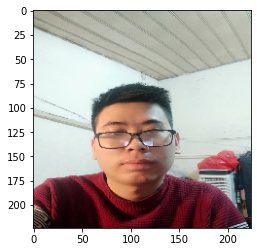

[[2.30841e-08 1.00000e+00]]


In [ ]:
i_image = load_img(img_name, target_size=(224, 224))
test_image = img_to_array(i_image)
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.
result = model.predict(test_image)
plt.imshow(i_image)
plt.show()
print(result)